## **Requirement**

In [4]:
!pip install tensorflowjs
!pip install TensorFlow==2.15.0
!pip install tensorflow-decision-forests==1.8.1

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.16.0
    Uninstalling tf_keras-2.16.0:
      Successfully uninstalled tf_keras-2.16.0


## **Create Model Laptop Lens**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
import tensorflow as tf

# Load the dataset
url = 'https://raw.githubusercontent.com/C4AnN/Laptop_Lens/main/ML/Dataset/Data_Barang_Keluar.csv'
store_sales = pd.read_csv(url)
store_sales['date'] = pd.to_datetime(store_sales['date'])

# Drop rows with NaN values
store_sales.dropna(inplace=True)

# Function to categorize price
def categorize_price(price):
    if price < 8000000:
        return 'low'
    elif 8000000 <= price < 16000000:
        return 'mid'
    else:
        return 'high'

# Categorize price and clean data
store_sales['category'] = store_sales['price'].apply(categorize_price)
store_sales = store_sales.drop(['name', 'price'], axis=1)

# Function to process each category
def process_category(data, category_name, window_size):
    tf.keras.backend.clear_session()

    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("W-SUN").dt.to_timestamp()

    weekly_sales = data.groupby('date').sum().reset_index()

    print(f"\nCategory: {category_name}")
    print(f"Weekly sales data shape: {weekly_sales.shape}")

    # Calculate sales difference
    weekly_sales['sales_diff'] = weekly_sales['sales'].diff()
    weekly_sales = weekly_sales.dropna()
    print(f"Weekly sales data after differencing shape: {weekly_sales.shape}")

    # Determine appropriate window size based on available data
    available_data_length = weekly_sales.shape[0]
    adjusted_window_size = min(window_size, available_data_length - 1)
    print(f"Adjusted window size: {adjusted_window_size}")

    # Prepare supervised data with the adjusted window size
    supervised_data = weekly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, adjusted_window_size + 1):
        col_name = 'week_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)
    print(f"Supervised data shape: {supervised_data.shape}")

    train_data = supervised_data[:-8]
    test_data = supervised_data[-4:]
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

    # Save the model in TensorFlow.js format
    tfjs_target_dir = f'best_model_tfjs_{category_name}'
    tfjs.converters.save_keras_model(model, tfjs_target_dir)

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = weekly_sales['date'][-4:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = weekly_sales['sales'][-5:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 4 weeks (approximately 1 month)
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(4):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + weekly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=weekly_sales['date'].iloc[-1] + pd.DateOffset(weeks=1), periods=4, freq='W-SUN')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return weekly_sales, predict_df, future_df, model

# Process and predict for each category using window size of 12 weeks (3 months)
window_size = 12

categories = ['low', 'mid', 'high']
results = {}

for category in categories:
    weekly_sales, predict_df, future_df, model = process_category(store_sales, category, window_size)
    if model is not None:
        results[category] = {
            'weekly_sales': weekly_sales,
            'predict_df': predict_df,
            'future_df': future_df,
            'model': model
        }
        tfjs_target_dir = f'best_model_tfjs_{category}'
        tfjs.converters.save_keras_model(model, tfjs_target_dir)
    else:
        print(f"Skipping category {category} due to insufficient data.")



Category: low
Weekly sales data shape: (261, 2)
Weekly sales data after differencing shape: (260, 3)
Adjusted window size: 12
Supervised data shape: (248, 13)
Train data shape: (240, 13)
Test data shape: (4, 13)
Epoch 1/200
15/15 [==============================] - 6s 85ms/step - loss: 0.1107 - val_loss: 0.2468
Epoch 2/200
15/15 [==============================] - 1s 57ms/step - loss: 0.1084 - val_loss: 0.2400
Epoch 3/200
15/15 [==============================] - 1s 53ms/step - loss: 0.1075 - val_loss: 0.1870
Epoch 4/200
15/15 [==============================] - 1s 52ms/step - loss: 0.1097 - val_loss: 0.2363
Epoch 5/200
15/15 [==============================] - 1s 39ms/step - loss: 0.1059 - val_loss: 0.2095
Epoch 6/200
15/15 [==============================] - 0s 28ms/step - loss: 0.1065 - val_loss: 0.2176
Epoch 7/200
15/15 [==============================] - 0s 27ms/step - loss: 0.1053 - val_loss: 0.2258
Epoch 8/200
15/15 [==============================] - 0s 27ms/step - loss: 0.1057 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step

Category: mid
Weekly sales data shape: (261, 2)
Weekly sales data after differencing shape: (260, 3)
Adjusted window size: 12
Supervised data shape: (248, 13)
Train data shape: (240, 13)
Test data shape: (4, 13)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
15/15 [==============================] - 4s 93ms/step - loss: 0.1238 - val_loss: 0.0422
Epoch 2/200
15/15 [==============================] - 1s 47ms/step - loss: 0.1186 - val_loss: 0.0391
Epoch 3/200
15/15 [==============================] - 0s 27ms/step - loss: 0.1175 - val_loss: 0.0384
Epoch 4/200
15/15 [==============================] - 0s 28ms/step - loss: 0.1167 - val_loss: 0.0375
Epoch 5/200
15/15 [==============================] - 0s 27ms/step - loss: 0.1151 - val_loss: 0.0402
Epoch 6/200
15/15 [==============================] - 0s 27ms/step - loss: 0.1177 - val_loss: 0.0401
Epoch 7/200
15/15 [==============================] - 0s 28ms/step - loss: 0.1202 - val_loss: 0.0413
Epoch 8/200
15/15 [==============================] - 0s 26ms/step - loss: 0.1169 - val_loss: 0.0431
Epoch 9/200
15/15 [==============================] - 0s 28ms/step - loss: 0.1188 - val_loss: 0.0389
Epoch 10/200
15/15 [==============================] - 0s 27ms/step - loss: 0.1166 - val_loss: 0.0380

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step

Category: high
Weekly sales data shape: (261, 2)
Weekly sales data after differencing shape: (260, 3)
Adjusted window size: 12
Supervised data shape: (248, 13)
Train data shape: (240, 13)
Test data shape: (4, 13)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
15/15 [==============================] - 3s 55ms/step - loss: 0.0989 - val_loss: 0.0475
Epoch 2/200
15/15 [==============================] - 0s 27ms/step - loss: 0.0944 - val_loss: 0.0319
Epoch 3/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0954 - val_loss: 0.0569
Epoch 4/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0937 - val_loss: 0.0614
Epoch 5/200
15/15 [==============================] - 0s 27ms/step - loss: 0.0947 - val_loss: 0.0586
Epoch 6/200
15/15 [==============================] - 0s 27ms/step - loss: 0.0949 - val_loss: 0.0648
Epoch 7/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0943 - val_loss: 0.0648
Epoch 8/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0924 - val_loss: 0.0520
Epoch 9/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0951 - val_loss: 0.0505
Epoch 10/200
15/15 [==============================] - 0s 27ms/step - loss: 0.0943 - val_loss: 0.0623

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Visualization**

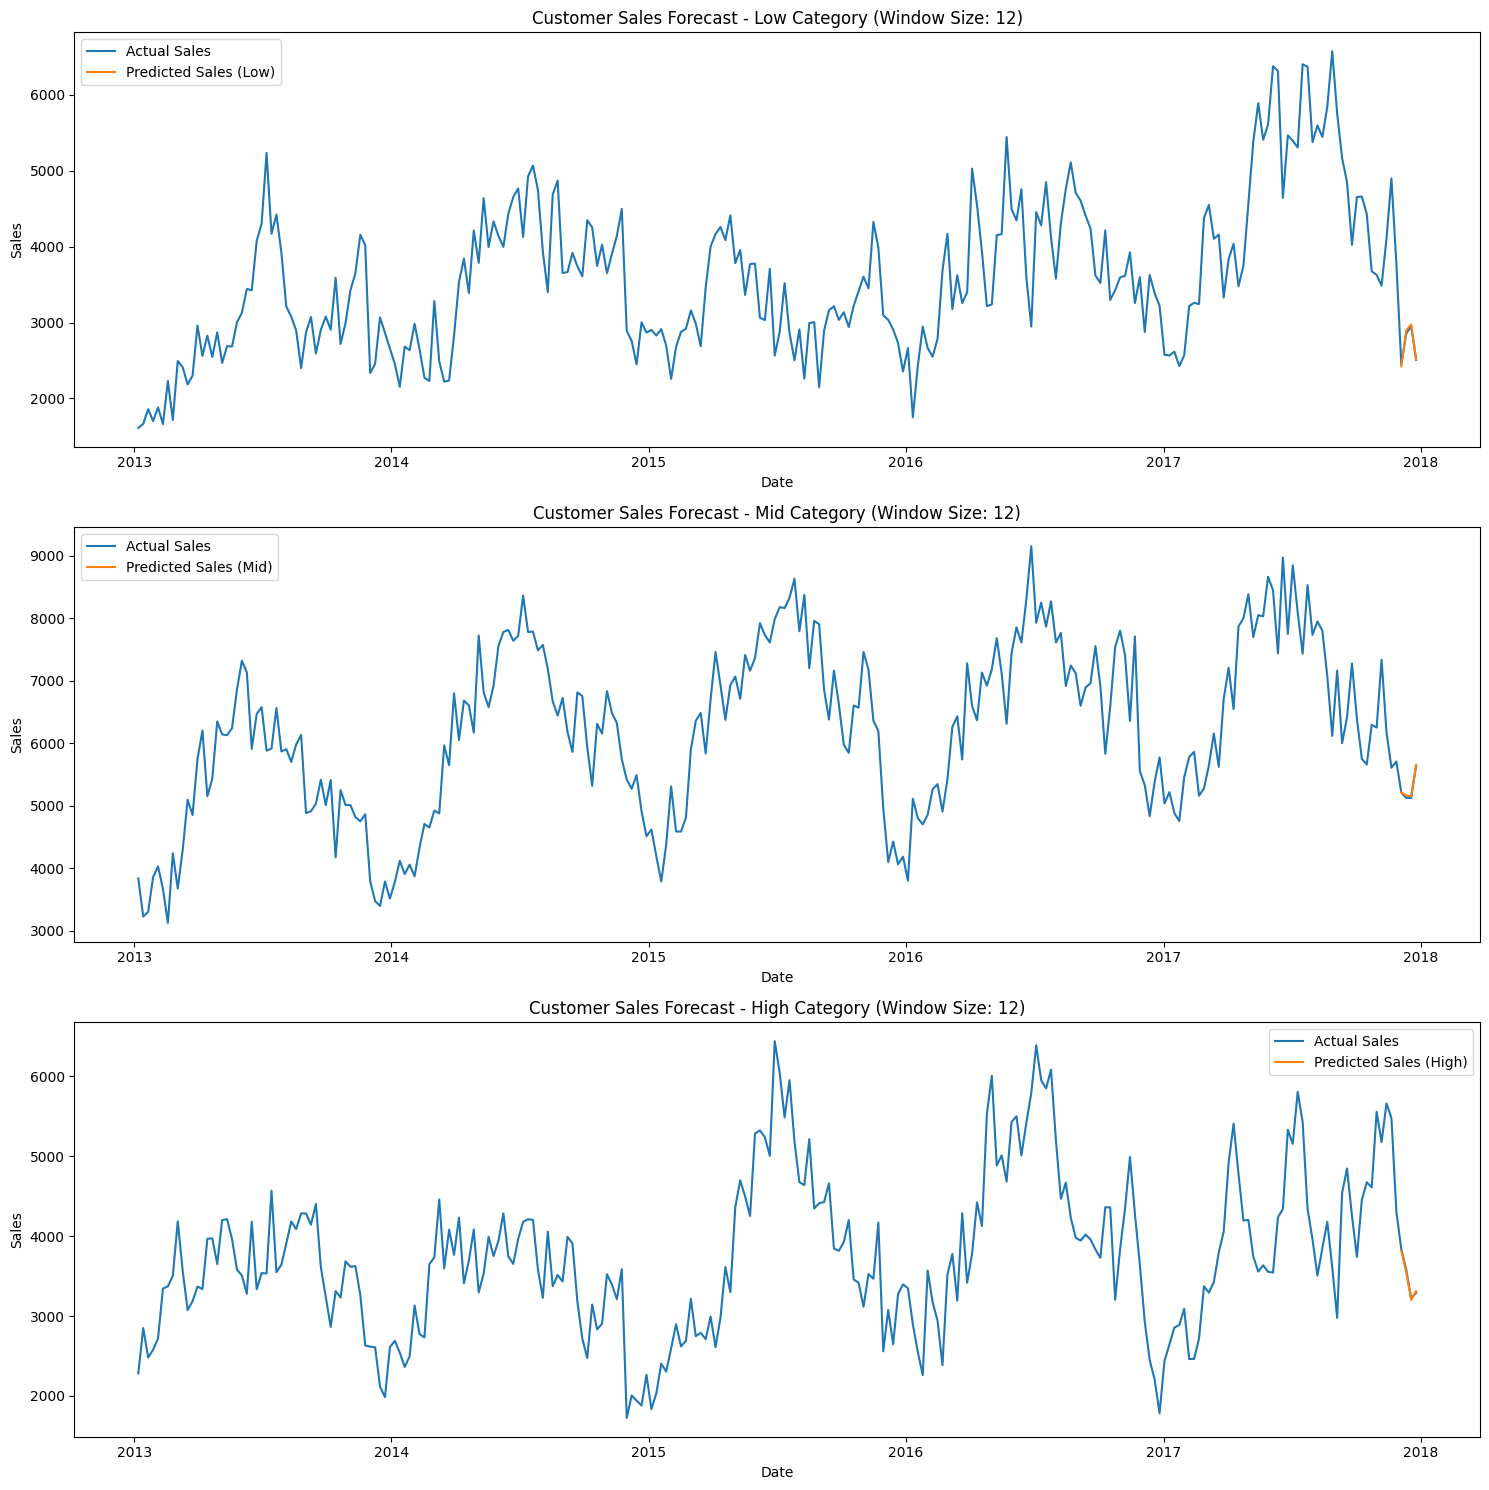

In [2]:
# Plot predictions by category
plt.figure(figsize=(15, 15))

if 'low' in results:
    low_sales = results['low']['weekly_sales']
    low_predict_df = results['low']['predict_df']
    # Low category plot
    plt.subplot(3, 1, 1)
    plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
    plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
    plt.title("Customer Sales Forecast - Low Category (Window Size: 12)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
else:
    print("Skipping Low category plot due to insufficient data.")

if 'mid' in results:
    mid_sales = results['mid']['weekly_sales']
    mid_predict_df = results['mid']['predict_df']
    # Mid category plot
    plt.subplot(3, 1, 2)
    plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
    plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
    plt.title("Customer Sales Forecast - Mid Category (Window Size: 12)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
else:
    print("Skipping Mid category plot due to insufficient data.")

if 'high' in results:
    high_sales = results['high']['weekly_sales']
    high_predict_df = results['high']['predict_df']
    # High category plot
    plt.subplot(3, 1, 3)
    plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
    plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
    plt.title("Customer Sales Forecast - High Category (Window Size: 12)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
else:
    print("Skipping High category plot due to insufficient data.")

plt.tight_layout()
plt.show()
